In [2]:
from gym import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [3]:
# Create the environment
class StockTradingEnvironment():
    def __init__(self, csv_file):  
        self.data = pd.read_csv(csv_file)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,))  # Dimension of the state space
        self.action_space = spaces.Discrete(3)  # Dimension of the action space: 0 represents sell, 1 represents buy, 2 represents hold
        self.current_step = 0  # Current time step
        self.trade_amount = 0
        self.cash_balance = 100000  # Initial cash balance
        self.stock_quantity = 0  # Initial stock holdings set to 0
        self.stock_price = self.data.iloc[0]['open']  # Initial stock price
        self.total_assets = self.cash_balance  # Initial total assets
        self.previous_cash_balance = 0  # Cash balance from the previous time step
        self.previous_stock_quantity = 0  # Stock quantity from the previous time step
        self.previous_price = 0  # Price from the previous time step

    def reset(self):  # Reset the environment to its initial state
        self.current_step = 0
        self.trade_amount = 0
        self.cash_balance = 100000
        self.stock_quantity = 0
        self.stock_price = self.data.iloc[0]['open']
        self.total_assets = self.cash_balance
        self.previous_cash_balance = 0  # Cash balance from the previous time step
        self.previous_stock_quantity = 0  # Stock quantity from the previous time step
        self.previous_price = 0  # Price from the previous time step

        return self._get_observation()

    def step(self, action):  # Execute an action and observe the next state, reward, and whether the episode is over
        self._take_action(action)
        self.current_step += 1
        reward = self._get_reward()
        done = self.current_step >= len(self.data) - 1
        return self._get_observation(), reward, done, {}

    def _get_observation(self):  # get_state: Observations of the environment
        current_price = self.data.iloc[self.current_step]['close']
        observation = [current_price, self.stock_quantity, 0, 0, 0, 0]  # Extend the observation to length 6 to avoid errors
        return torch.tensor(observation, dtype=torch.float)  # Return the observation as a tensor

    def _take_action(self, action):  # Action space
        trade_amount = 0
        current_price = self.data.iloc[self.current_step]['close']
        
        if action == 0:  # Sell
            trade_amount = int(self.stock_quantity * 0.5)
            if trade_amount > 0:
                self.cash_balance += trade_amount * current_price  # Total assets
                self.stock_quantity -= trade_amount

        elif action == 1:  # Buy
            trade_amount = int(self.cash_balance / (2 * current_price))
            if trade_amount > 0:
                self.cash_balance -= trade_amount * current_price
                self.stock_quantity += trade_amount

        # print("action:  ", action)
        # print("trade_amount:  ", trade_amount)
        self.trade_amount = trade_amount

        # Update the state from the previous time step
        self.previous_cash_balance = self.cash_balance
        self.previous_stock_quantity = self.stock_quantity
        self.previous_price = current_price

    def _get_reward(self):
        current_price = self.data.iloc[self.current_step]['close']
        current_total_assets = self.cash_balance + self.stock_quantity * current_price
        previous_total_assets = self.previous_cash_balance + self.previous_stock_quantity * self.previous_price
        reward = current_total_assets - previous_total_assets
        return reward


In [4]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration factor
        self.epsilon_decay = 0.995  # Decay rate of the exploration factor
        self.epsilon_min = 0.01  # Minimum value of the exploration factor
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.criterion = nn.MSELoss()

    def decay_epsilon(self):  # When epsilon=1, exploration is completely random
        self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state, done):  # Experience replay
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        q_values = self.model(state)
        return torch.argmax(q_values).item()
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = state.to(device)
            next_state = next_state.to(device)

        # Calculate target Q value
        target = reward
        if not done:
            next_q_values = self.model(next_state).detach()
            target += self.gamma * torch.max(next_q_values).item()

        # Get current Q values
        q_values = self.model(state)
        target_q_values = q_values.clone()
        target_q_values[action] = target  # Update Q value for the corresponding action

        # Fix loss calculation
        # Ensure q_values and target_q_values have consistent shapes
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


Using device: cuda


C:\Users\dongs\AppData\Local\Temp\ipykernel_944\4030412723.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.model.load_state_dict(torch.load('dqn_model.pth'))


Total Reward on Test Set: 18543.288894653306


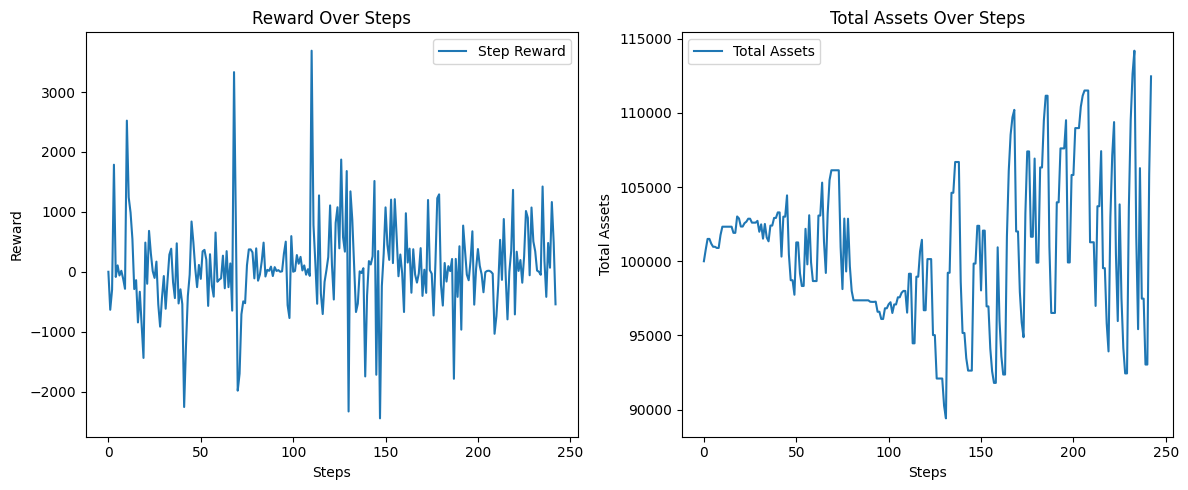

In [5]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the test data and initialize the environment
env = StockTradingEnvironment('test_data.csv')  # Replace with your test data file path

# Initialize the agent
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

# Load the trained model weights
agent.model.load_state_dict(torch.load('dqn_model.pth'))
agent.model.to(device)
agent.model.eval()  # Set the model to evaluation mode

# Testing loop
state = env.reset().to(device)
done = False
total_reward = 0
rewards = []  # Record step rewards
total_assets = []  # Record total assets

while not done:
    with torch.no_grad():  # No gradient computation during testing
        action = agent.act(state)  # Agent selects an action
    next_state, reward, done, _ = env.step(action)  # Environment executes the action
    total_reward += reward
    rewards.append(reward)
    total_assets.append(env.cash_balance + env.stock_quantity * env.stock_price)  # Record total assets
    state = next_state.to(device)  # Update the state

# Print total reward on the test set
print(f"Total Reward on Test Set: {total_reward}")

# Visualize rewards and total assets
plt.figure(figsize=(12, 5))

# Step rewards plot
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Step Reward')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Reward Over Steps')
plt.legend()

# Total assets plot
plt.subplot(1, 2, 2)
plt.plot(total_assets, label='Total Assets')
plt.xlabel('Steps')
plt.ylabel('Total Assets')
plt.title('Total Assets Over Steps')
plt.legend()

plt.tight_layout()
plt.show()
